In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import KMeans
from collections import Counter
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Yardımcı Fonksiyonlar
def create_target(credit_data):
    bad_status = ['2', '3', '4', '5']
    
    grouped = credit_data.groupby('ID')
    target_labels = []
    ids = []
    
    for customer_id, group in grouped:
        customer_records = group['STATUS'].astype(str).tolist()
        
        has_bad_history = any(status in bad_status for status in customer_records)
        
        ids.append(customer_id)
        target_labels.append(1 if has_bad_history else 0)  # 1: Kötü müşteri, 0: İyi müşteri
    
    return pd.DataFrame({'ID': ids, 'TARGET': target_labels})

def preprocess_data_standard(df):
    cat_columns = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 
                 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
    
    df_processed = pd.get_dummies(df, columns=cat_columns, drop_first=True)
    
    df_processed = df_processed.drop('ID', axis=1)
    
    numeric_cols = df_processed.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        if col != 'TARGET':
            upper_limit = df_processed[col].quantile(0.99)
            df_processed.loc[df_processed[col] > upper_limit, col] = upper_limit
    
    target = df_processed['TARGET']
    features = df_processed.drop('TARGET', axis=1)
    
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)
    
    features_scaled_df['TARGET'] = target
    
    return features_scaled_df, features.columns

def balance_and_reduce_data(df, target_samples=6000):
    X = df.drop('TARGET', axis=1)
    y = df['TARGET']
    
    print("\nDengeleme Öncesi Sınıf Dağılımı:")
    print(Counter(y))
    
    smote_tomek = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
    
    print("Dengeleme Sonrası Sınıf Dağılımı:")
    print(Counter(y_resampled))
    
    X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    combined_df = X_resampled_df.copy()
    combined_df['TARGET'] = y_resampled
    
    class_0_df = combined_df[combined_df['TARGET'] == 0]
    class_1_df = combined_df[combined_df['TARGET'] == 1]
    
    samples_per_class = target_samples // 2
    
    def get_strategic_samples(df, n_samples, n_clusters=30):
        X_class = df.drop('TARGET', axis=1)
        
        if n_samples < n_clusters:
            n_clusters = n_samples
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        df['cluster'] = kmeans.fit_predict(X_class)
        
        samples_per_cluster = max(1, n_samples // n_clusters)
        
        selected_samples = pd.DataFrame()
        
        for i in range(n_clusters):
            cluster_samples = df[df['cluster'] == i]
            
            if len(cluster_samples) <= samples_per_cluster:
                selected_from_cluster = cluster_samples
            else:
                cluster_center = kmeans.cluster_centers_[i]
                
                X_cluster = cluster_samples.drop(['TARGET', 'cluster'], axis=1)
                distances = np.sqrt(((X_cluster - cluster_center) ** 2).sum(axis=1))
                
                closest_indices = distances.argsort()[:samples_per_cluster]
                selected_from_cluster = cluster_samples.iloc[closest_indices]
            
            selected_samples = pd.concat([selected_samples, selected_from_cluster])
        
        if len(selected_samples) < n_samples:
            remaining = n_samples - len(selected_samples)
            unselected = df[~df.index.isin(selected_samples.index)]
            
            if len(unselected) > 0:
                random_samples = unselected.sample(min(remaining, len(unselected)), random_state=42)
                selected_samples = pd.concat([selected_samples, random_samples])
        
        selected_samples = selected_samples.drop('cluster', axis=1)
        
        return selected_samples.iloc[:n_samples]
    
    selected_class_0 = get_strategic_samples(class_0_df, samples_per_class)
    selected_class_1 = get_strategic_samples(class_1_df, samples_per_class)
    
    reduced_balanced_df = pd.concat([selected_class_0, selected_class_1])
    
    reduced_balanced_df = reduced_balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"Azaltma Sonrası Veri Boyutu: {reduced_balanced_df.shape}")
    print(f"Azaltma Sonrası Sınıf Dağılımı:")
    print(Counter(reduced_balanced_df['TARGET']))
    
    return reduced_balanced_df

def split_data(df):
    X = df.drop('TARGET', axis=1)
    y = df['TARGET']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    
    print(f"\nEğitim Seti Boyutu: {X_train.shape}, Test Seti Boyutu: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test

def create_optimized_models():
    models = {
        'KNN': KNeighborsClassifier(
            n_neighbors=5, weights='distance', algorithm='auto', p=2,
            metric='minkowski', n_jobs=-1
        ),
        'Naive Bayes': GaussianNB(
            var_smoothing=1e-9
        ),
        'Decision Tree': DecisionTreeClassifier(
            criterion='gini', max_depth=6, min_samples_split=20, min_samples_leaf=8,
            class_weight='balanced', random_state=42
        ),
        'SVM (Linear)': SVC(
            kernel='linear', C=0.5, class_weight='balanced', max_iter=500,
            probability=True, random_state=42
        ),
        'SVM (Poly)': SVC(
            kernel='poly', degree=2, C=0.5, gamma='scale', class_weight='balanced',
            max_iter=500, probability=True, random_state=42
        ),
        'SVM (RBF)': SVC(
            kernel='rbf', C=5.0, gamma='auto', class_weight='balanced',
            max_iter=500, probability=True, random_state=42
        ),
        'MLP': MLPClassifier(
            hidden_layer_sizes=(50, 25), activation='relu', solver='adam',
            alpha=0.001, batch_size=64, learning_rate='adaptive', max_iter=200,
            early_stopping=True, random_state=42
        ),
        'Logistic Regression': LogisticRegression(
            penalty='l2', C=0.5, solver='liblinear', class_weight='balanced',
            max_iter=300, n_jobs=-1, random_state=42
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=50, criterion='gini', max_depth=8, min_samples_split=20,
            min_samples_leaf=8, class_weight='balanced', bootstrap=True,
            n_jobs=-1, random_state=42
        )
    }
    return models

def specificity_score(y_true, y_pred):
    """Özgüllük (specificity) metriğini hesaplayan fonksiyon"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'specificity': make_scorer(specificity_score),
    'mcc': make_scorer(matthews_corrcoef),
    'roc_auc': 'roc_auc',
}

def evaluate_models(X_train, X_test, y_train, y_test, models, cv=10):

    results = {}
    cv_results = {}
    confusion_matrices = {}
    training_times = {}
    
    
    
    for name, model in models.items():
        print(f"\n{name} modeli eğitiliyor...")
        start_time = time.time()
        
        model.fit(X_train, y_train)
        
        train_time = time.time() - start_time
        training_times[name] = train_time
        
        y_pred = model.predict(X_test)
        
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices[name] = cm
        
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'specificity': specificity_score(y_test, y_pred),
            'mcc': matthews_corrcoef(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred),
            'training_time': train_time
        }
        
        cv_scores = {}
        for metric, scorer in scoring.items():
            if metric == 'roc_auc' and not hasattr(model, "predict_proba"):
                cv_scores[metric] = "Not available"
                continue
                
            try:
                scores = cross_val_score(model, X_train, y_train, cv=10, scoring=scorer)
                cv_scores[metric] = scores.mean()
            except Exception as e:
                cv_scores[metric] = f"Error: {e}"
        
        cv_results[name] = cv_scores
    
    return results, cv_results, confusion_matrices, training_times

def create_results_table(results, cv_results):
    """Sonuçları tablo olarak düzenle"""
    table = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 
                                 'Specificity', 'MCC', 'ROC-AUC', 'Training Time (s)'])
    
    for name, metrics in results.items():
        row = {
            'Model': name,
            'Accuracy': f"{metrics['accuracy']:.4f} ({cv_results[name]['accuracy']:.4f})",
            'Precision': f"{metrics['precision']:.4f} ({cv_results[name]['precision']:.4f})",
            'Recall': f"{metrics['recall']:.4f} ({cv_results[name]['recall']:.4f})",
            'F1-Score': f"{metrics['f1']:.4f} ({cv_results[name]['f1']:.4f})",
            'Specificity': f"{metrics['specificity']:.4f} ({cv_results[name]['specificity']:.4f})" if isinstance(cv_results[name]['specificity'], float) else f"{metrics['specificity']:.4f} (N/A)",
            'MCC': f"{metrics['mcc']:.4f} ({cv_results[name]['mcc']:.4f})" if isinstance(cv_results[name]['mcc'], float) else f"{metrics['mcc']:.4f} (N/A)",
            'ROC-AUC': f"{metrics['roc_auc']:.4f} ({cv_results[name]['roc_auc']:.4f})" if isinstance(cv_results[name]['roc_auc'], float) else f"{metrics['roc_auc']:.4f} (N/A)",
            'Training Time (s)': f"{metrics['training_time']:.2f}"
        }
        table = pd.concat([table, pd.DataFrame([row])], ignore_index=True)
    
    return table

def plot_confusion_matrices(confusion_matrices, table_name):
    """Tüm modeller için confusion matrixleri görselleştir"""
    plt.figure(figsize=(20, 15))
    
    for i, (name, cm) in enumerate(confusion_matrices.items(), 1):
        plt.subplot(3, 3, i)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'{name} - Confusion Matrix')
        plt.xlabel('Tahmin Edilen Sınıf')
        plt.ylabel('Gerçek Sınıf')
    
    plt.tight_layout()
    plt.savefig(f'{table_name}_confusion_matrices.png')
    plt.show()

def find_best_models(results_table, metric='F1-Score'):
    """Belirli bir metriğe göre en iyi 3 modeli bul"""
    metric_values = results_table[metric].apply(lambda x: float(x.split(' ')[0]))
    
    best_models = results_table.iloc[metric_values.nlargest(3).index][['Model', metric]]
    
    return best_models

def genetic_algorithm_feature_selection(X_train, y_train, X_test):
    """Random Forest tabanlı özellik seçimi"""
    selector = SelectFromModel(
        RandomForestClassifier(n_estimators=100, random_state=42),
        threshold="median"
    )
    
    selector.fit(X_train, y_train)
    
    selected_features = X_train.columns[selector.get_support()]
    print(f"\nGenetik Algoritma ile Seçilen Özellik Sayısı: {len(selected_features)}")
    
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    
    return X_train_selected, X_test_selected, selected_features

def apply_pca(X_train, X_test, variance_threshold=0.90):
    """PCA ile boyut indirgeme"""
    pca = PCA(n_components=variance_threshold, svd_solver='full')
    
    pca.fit(X_train)
    
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    pca_columns = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]
    
    X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_columns)
    X_test_pca_df = pd.DataFrame(X_test_pca, columns=pca_columns)
    
    print(f"\nPCA ile {X_train_pca.shape[1]} bileşene indirgendi. Açıklanan varyans: {variance_threshold:.2f}")
    
    return X_train_pca_df, X_test_pca_df

In [ ]:
def main():
    try:
        print("Veri setleri yükleniyor...")
        application_data = pd.read_csv('application_record.csv')
        credit_data = pd.read_csv('credit_record.csv')
        
        print("Application Data Shape:", application_data.shape)
        print("Credit Data Shape:", credit_data.shape)
        
        print("\nHedef değişkeni oluşturuluyor...")
        target_df = create_target(credit_data)
        print("Hedef Değişkeni Dağılımı:")
        print(target_df['TARGET'].value_counts())
        
        merged_data = application_data.merge(target_df, on='ID', how='inner')
        print("Birleştirilmiş Veri Seti Boyutu:", merged_data.shape)
        
        print("\nVeri StandardScaler ile ön işleniyor...")
        processed_data, feature_names = preprocess_data_standard(merged_data)
        print("İşlenmiş Veri Boyutu:", processed_data.shape)
        
        print("\nVeri dengeleniyor ve boyutu azaltılıyor...")
        balanced_data = balance_and_reduce_data(processed_data, target_samples=6000)
        
        X_train, X_test, y_train, y_test = split_data(balanced_data)
        
        models = create_optimized_models()
        
        # --- TABLO 1: STANDALONE CLASSIFIER METRICS ---
        print("\n--- TABLO 1: STANDALONE CLASSIFIER METRICS ---")
        results, cv_results, confusion_matrices, training_times = evaluate_models(
            X_train, X_test, y_train, y_test, models, cv=10)
        
        table1 = create_results_table(results, cv_results)
        print("\nTABLO 1: STANDALONE CLASSIFIER METRICS RESULTS (StandardScaler)")
        print(table1)
        
        plot_confusion_matrices(confusion_matrices, "table1_standardscaler")
        
        best_models_table1 = find_best_models(table1)
        print("\nTABLO 1 için En İyi 3 Model (F1-Score'a göre):")
        print(best_models_table1)
        
        # --- TABLO 2: GENETIC ALGORITHM METRICS ---
        print("\n--- TABLO 2: GENETIC ALGORITHM METRICS ---")
        
        X_train_ga, X_test_ga, selected_features = genetic_algorithm_feature_selection(
            X_train, y_train, X_test)
        
        results_ga, cv_results_ga, confusion_matrices_ga, training_times_ga = evaluate_models(
            X_train_ga, X_test_ga, y_train, y_test, models, cv=10)
        
        table2 = create_results_table(results_ga, cv_results_ga)
        print("\nTABLO 2: GENETIC ALGORITHM METRICS RESULTS (StandardScaler)")
        print(table2)
        
        plot_confusion_matrices(confusion_matrices_ga, "table2_standardscaler")
        
        best_models_table2 = find_best_models(table2)
        print("\nTABLO 2 için En İyi 3 Model (F1-Score'a göre):")
        print(best_models_table2)
        
        # --- TABLO 3: PCA METRICS ---
        print("\n--- TABLO 3: PCA METRICS ---")
        
        X_train_pca, X_test_pca = apply_pca(X_train, X_test)
        
        results_pca, cv_results_pca, confusion_matrices_pca, training_times_pca = evaluate_models(
            X_train_pca, X_test_pca, y_train, y_test, models, cv=10)
        
        table3 = create_results_table(results_pca, cv_results_pca)
        print("\nTABLO 3: PCA METRICS RESULTS (StandardScaler)")
        print(table3)
        
        plot_confusion_matrices(confusion_matrices_pca, "table3_standardscaler")
        
        best_models_table3 = find_best_models(table3)
        print("\nTABLO 3 için En İyi 3 Model (F1-Score'a göre):")
        print(best_models_table3)
        
        table1.to_csv("table1_ss.csv", index=False)
        table2.to_csv("table2_ss.csv", index=False)
        table3.to_csv("table3_ss.csv", index=False)
        
        print("\n--- SONUÇ ÖZETİ (StandardScaler) ---")
        
        performance_comparison = pd.DataFrame({
            'Model': table1['Model'],
            'Tablo 1 F1-Score': table1['F1-Score'].apply(lambda x: float(x.split(' ')[0])),
            'Tablo 2 F1-Score': table2['F1-Score'].apply(lambda x: float(x.split(' ')[0])),
            'Tablo 3 F1-Score': table3['F1-Score'].apply(lambda x: float(x.split(' ')[0]))
        })
        
        print("\nTüm Tabloların F1-Score Karşılaştırması:")
        print(performance_comparison)
        
        plt.figure(figsize=(15, 10))
        
        models = performance_comparison['Model']
        t1_scores = performance_comparison['Tablo 1 F1-Score']
        t2_scores = performance_comparison['Tablo 2 F1-Score']
        t3_scores = performance_comparison['Tablo 3 F1-Score']
        
        x = np.arange(len(models))
        width = 0.25
        
        plt.bar(x - width, t1_scores, width, label='Standart Modeller', color='skyblue')
        plt.bar(x, t2_scores, width, label='Genetik Algoritma', color='orange')
        plt.bar(x + width, t3_scores, width, label='PCA', color='green')
        
        plt.xlabel('Modeller')
        plt.ylabel('F1-Score')
        plt.title('Tüm Yaklaşımların F1-Score Karşılaştırması (StandardScaler)')
        plt.xticks(x, models, rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.savefig('model_comparison_standardscaler.png')
        plt.show()
        
        print("\nStandardScaler ile analiz tamamlandı. Sonuçlar CSV dosyalarına ve grafik olarak kaydedildi.")
        
    except Exception as e:
        print(f"Hata oluştu: {e}")


Veri setleri yükleniyor...
Application Data Shape: (438557, 18)
Credit Data Shape: (1048575, 3)

Hedef değişkeni oluşturuluyor...
Hedef Değişkeni Dağılımı:
TARGET
0    45318
1      667
Name: count, dtype: int64
Birleştirilmiş Veri Seti Boyutu: (36457, 19)

Veri StandardScaler ile ön işleniyor...
İşlenmiş Veri Boyutu: (36457, 47)

Veri dengeleniyor ve boyutu azaltılıyor...

Dengeleme Öncesi Sınıf Dağılımı:
Counter({0: 35841, 1: 616})
Dengeleme Sonrası Sınıf Dağılımı:
Counter({0: 35834, 1: 35834})
Azaltma Sonrası Veri Boyutu: (6000, 47)
Azaltma Sonrası Sınıf Dağılımı:
Counter({0: 3000, 1: 3000})

Eğitim Seti Boyutu: (4500, 46), Test Seti Boyutu: (1500, 46)

--- TABLO 1: STANDALONE CLASSIFIER METRICS ---

KNN modeli eğitiliyor...

Naive Bayes modeli eğitiliyor...

Decision Tree modeli eğitiliyor...

SVM (Linear) modeli eğitiliyor...

SVM (Poly) modeli eğitiliyor...

SVM (RBF) modeli eğitiliyor...

MLP modeli eğitiliyor...

Logistic Regression modeli eğitiliyor...

Random Forest modeli eği

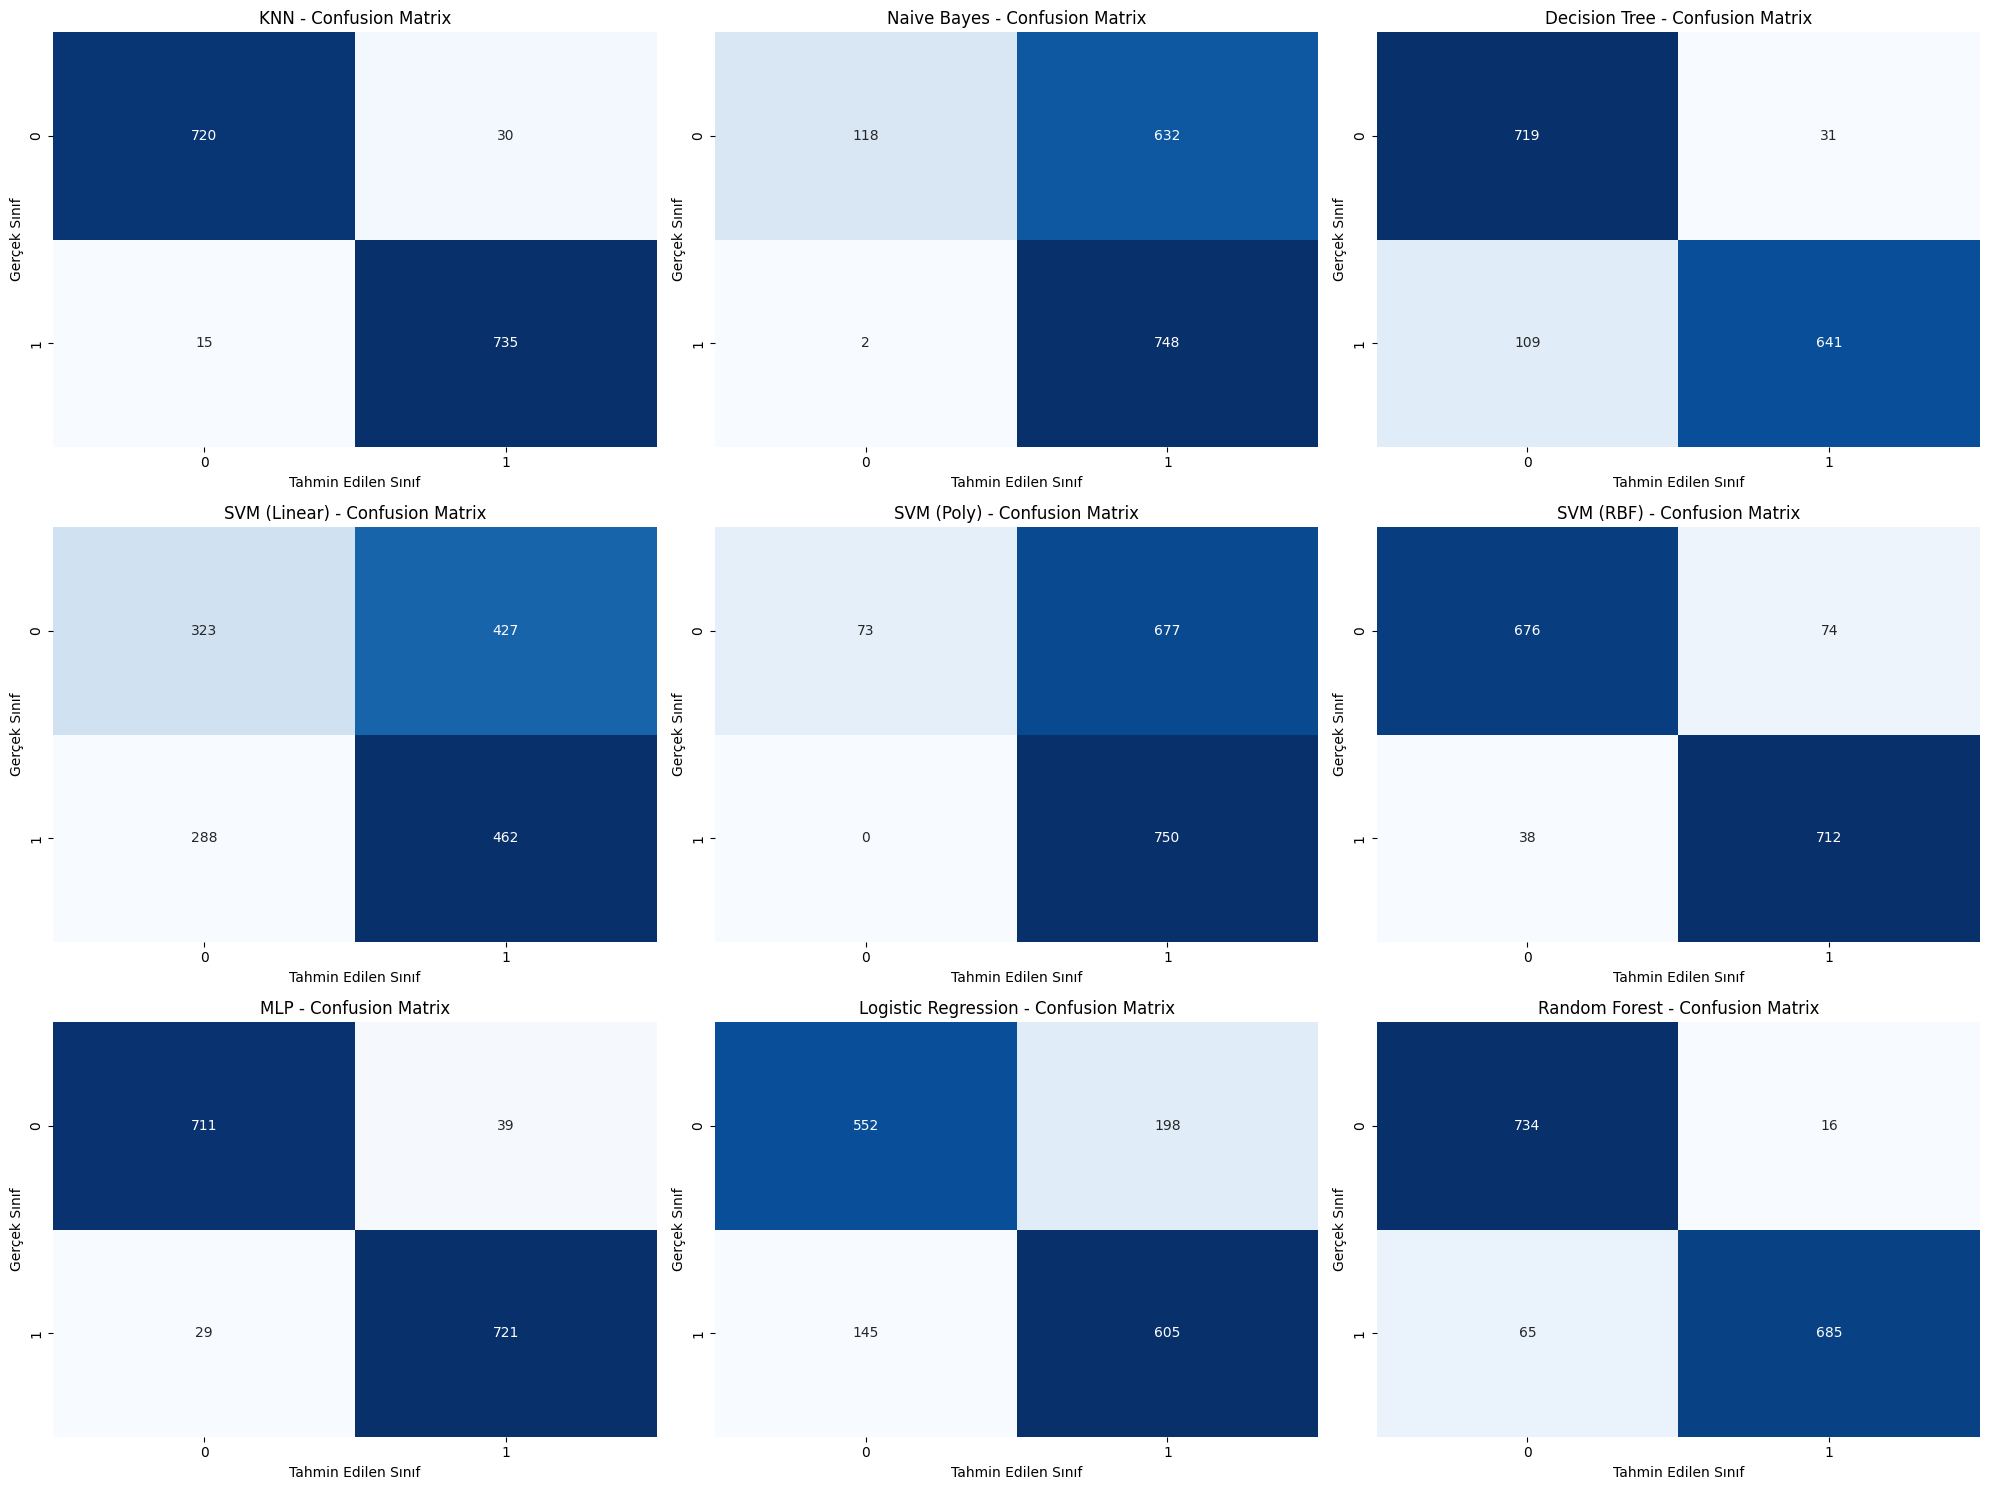


TABLO 1 için En İyi 3 Model (F1-Score'a göre):
           Model         F1-Score
0            KNN  0.9703 (0.9785)
6            MLP  0.9550 (0.9503)
8  Random Forest  0.9442 (0.9381)

--- TABLO 2: GENETIC ALGORITHM METRICS ---

Genetik Algoritma ile Seçilen Özellik Sayısı: 23

KNN modeli eğitiliyor...

Naive Bayes modeli eğitiliyor...

Decision Tree modeli eğitiliyor...

SVM (Linear) modeli eğitiliyor...

SVM (Poly) modeli eğitiliyor...

SVM (RBF) modeli eğitiliyor...

MLP modeli eğitiliyor...

Logistic Regression modeli eğitiliyor...

Random Forest modeli eğitiliyor...

TABLO 2: GENETIC ALGORITHM METRICS RESULTS (StandardScaler)
                 Model         Accuracy        Precision           Recall  \
0                  KNN  0.9700 (0.9787)  0.9596 (0.9704)  0.9813 (0.9876)   
1          Naive Bayes  0.6593 (0.6449)  0.7559 (0.7292)  0.4707 (0.4636)   
2        Decision Tree  0.9113 (0.8973)  0.9401 (0.9440)  0.8787 (0.8453)   
3         SVM (Linear)  0.6187 (0.4758)  0.6121 (0.48

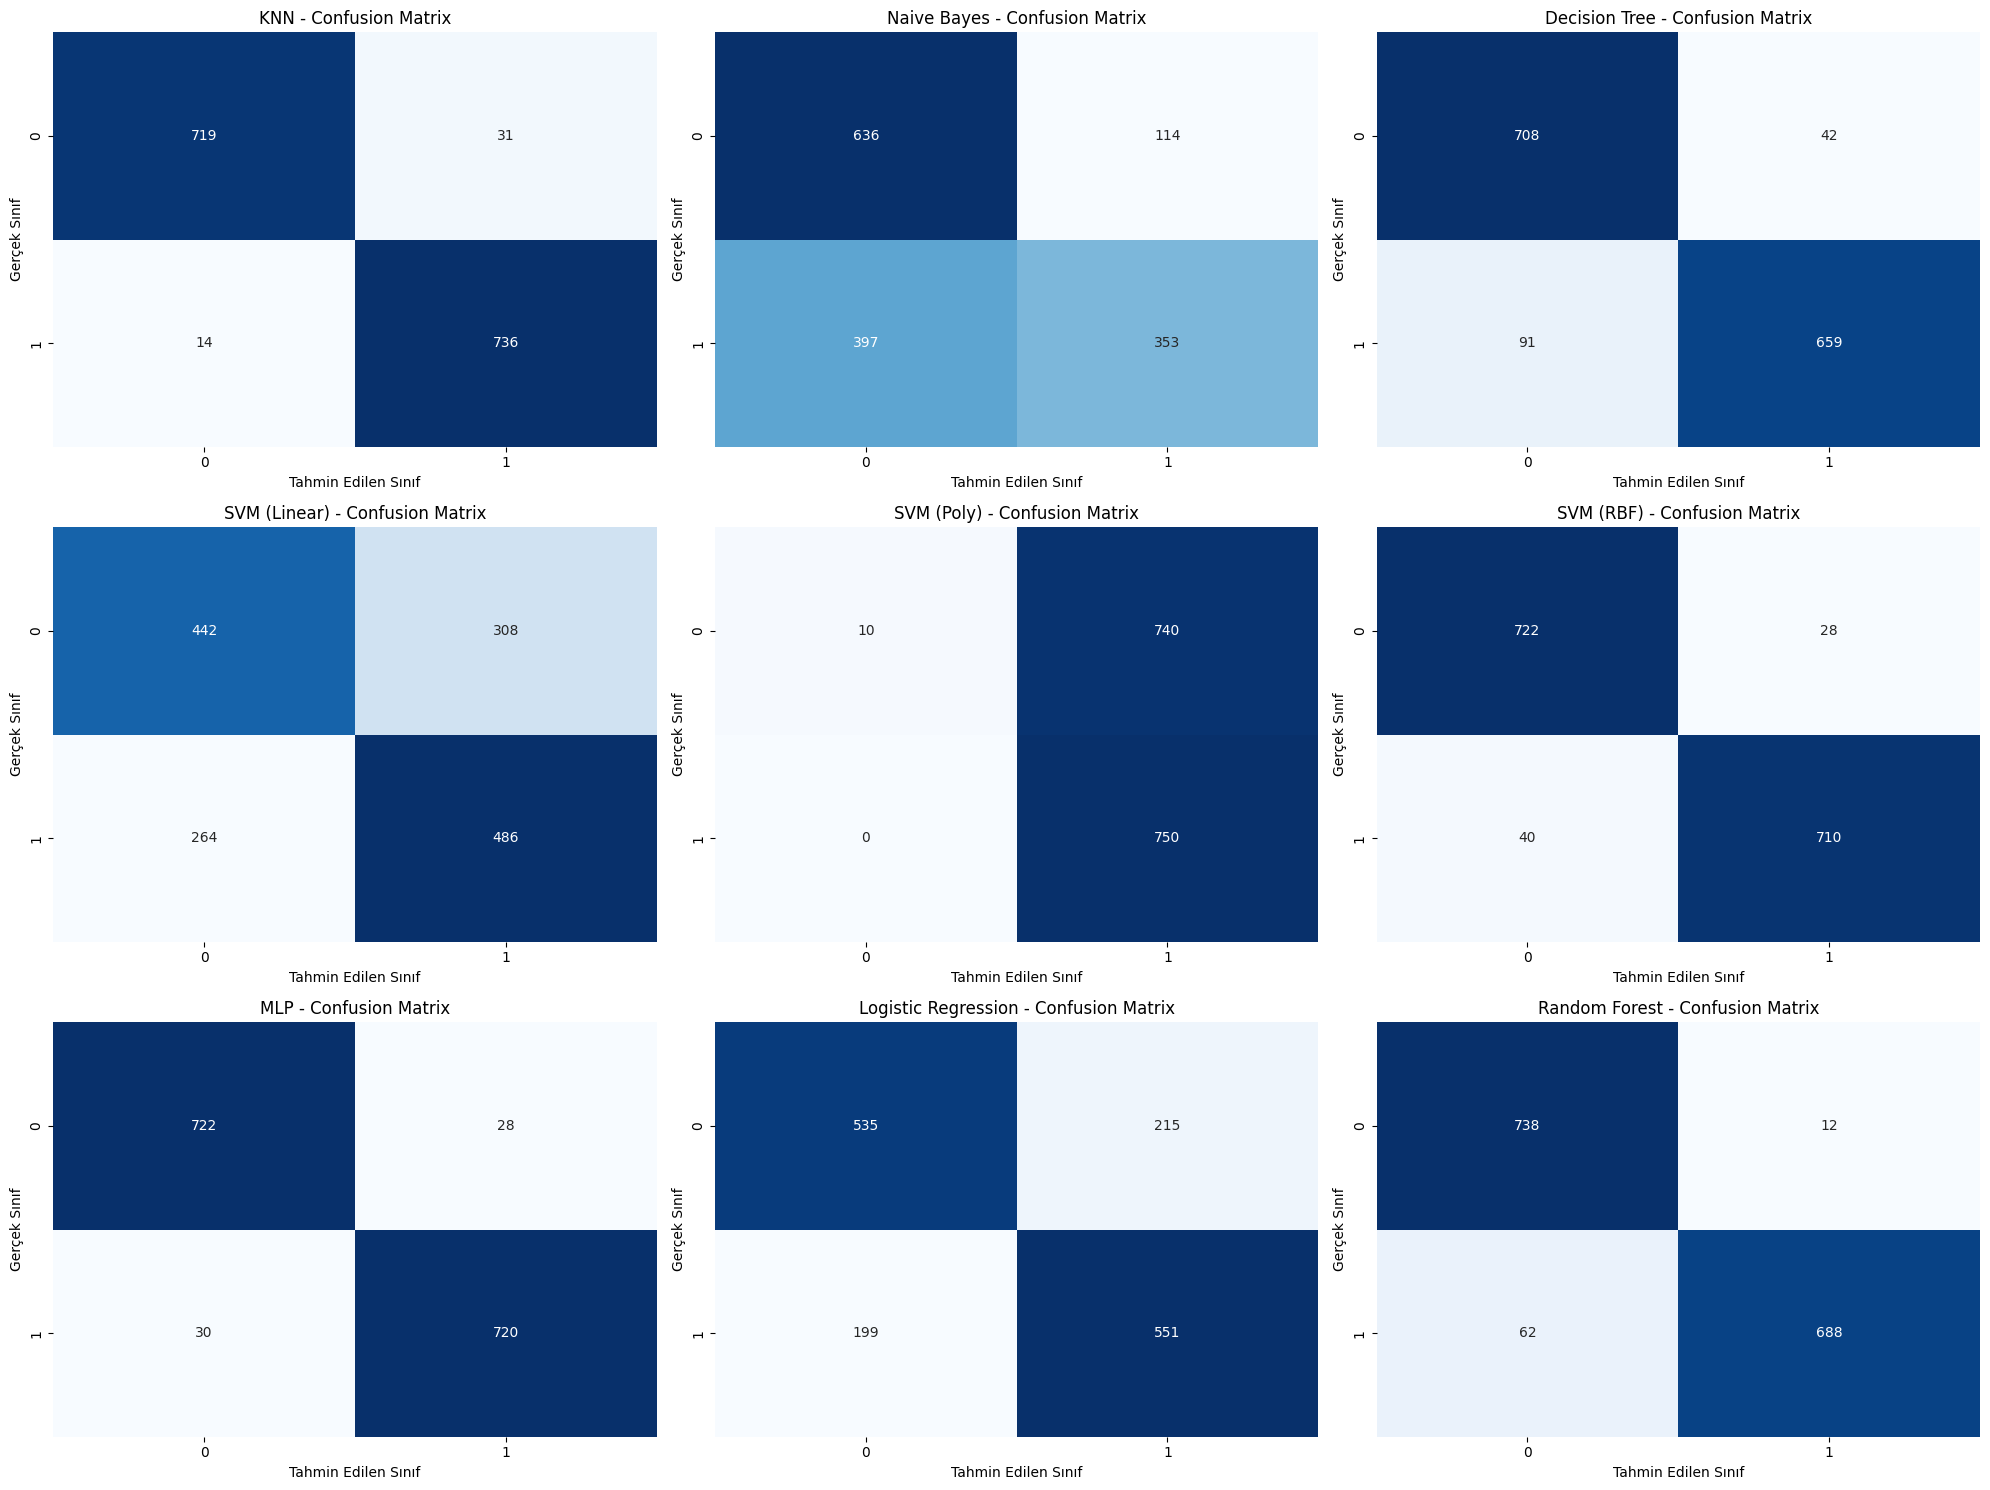


TABLO 2 için En İyi 3 Model (F1-Score'a göre):
       Model         F1-Score
0        KNN  0.9703 (0.9789)
6        MLP  0.9613 (0.9444)
5  SVM (RBF)  0.9543 (0.9475)

--- TABLO 3: PCA METRICS ---

PCA ile 27 bileşene indirgendi. Açıklanan varyans: 0.95

KNN modeli eğitiliyor...

Naive Bayes modeli eğitiliyor...

Decision Tree modeli eğitiliyor...

SVM (Linear) modeli eğitiliyor...

SVM (Poly) modeli eğitiliyor...

SVM (RBF) modeli eğitiliyor...

MLP modeli eğitiliyor...

Logistic Regression modeli eğitiliyor...

Random Forest modeli eğitiliyor...

TABLO 3: PCA METRICS RESULTS (StandardScaler)
                 Model         Accuracy        Precision           Recall  \
0                  KNN  0.9693 (0.9782)  0.9595 (0.9675)  0.9800 (0.9898)   
1          Naive Bayes  0.5693 (0.5847)  0.5426 (0.5514)  0.8840 (0.9084)   
2        Decision Tree  0.8460 (0.8442)  0.8176 (0.8056)  0.8907 (0.9116)   
3         SVM (Linear)  0.5280 (0.5473)  0.5233 (0.5399)  0.6293 (0.6560)   
4           S

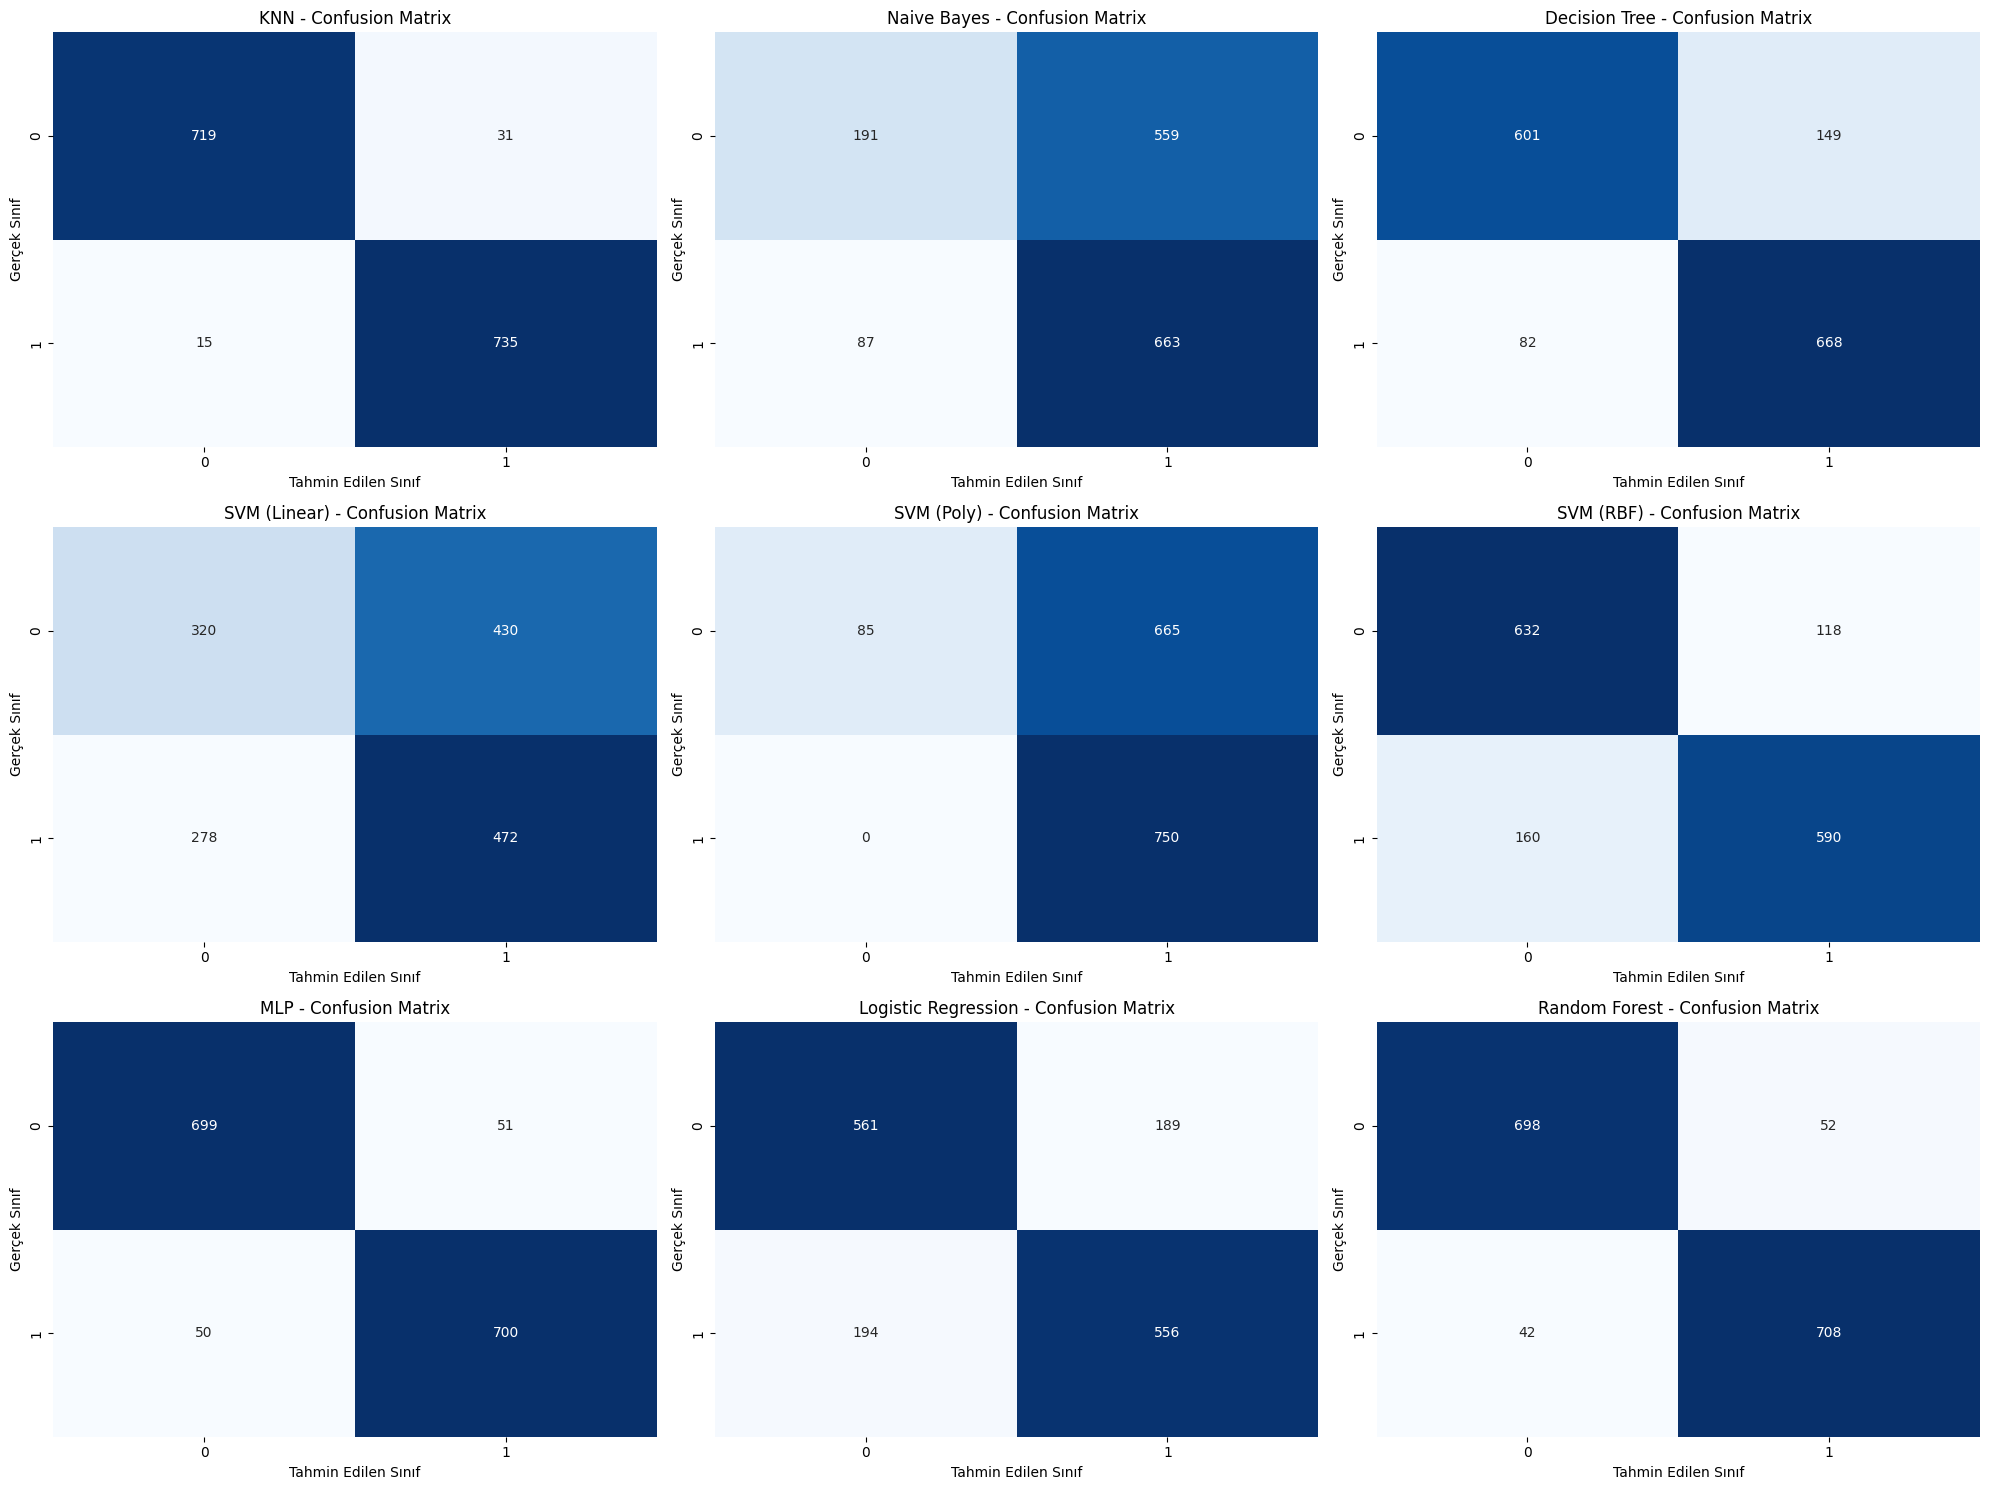


TABLO 3 için En İyi 3 Model (F1-Score'a göre):
           Model         F1-Score
0            KNN  0.9697 (0.9785)
8  Random Forest  0.9377 (0.9471)
6            MLP  0.9327 (0.9236)

--- SONUÇ ÖZETİ (StandardScaler) ---

Tüm Tabloların F1-Score Karşılaştırması:
                 Model  Tablo 1 F1-Score  Tablo 2 F1-Score  Tablo 3 F1-Score
0                  KNN            0.9703            0.9703            0.9697
1          Naive Bayes            0.7023            0.5801            0.6724
2        Decision Tree            0.9015            0.9083            0.8526
3         SVM (Linear)            0.5638            0.6295            0.5714
4           SVM (Poly)            0.6890            0.6696            0.6928
5            SVM (RBF)            0.9271            0.9543            0.8093
6                  MLP            0.9550            0.9613            0.9327
7  Logistic Regression            0.7791            0.7269            0.7438
8        Random Forest            0.9442   

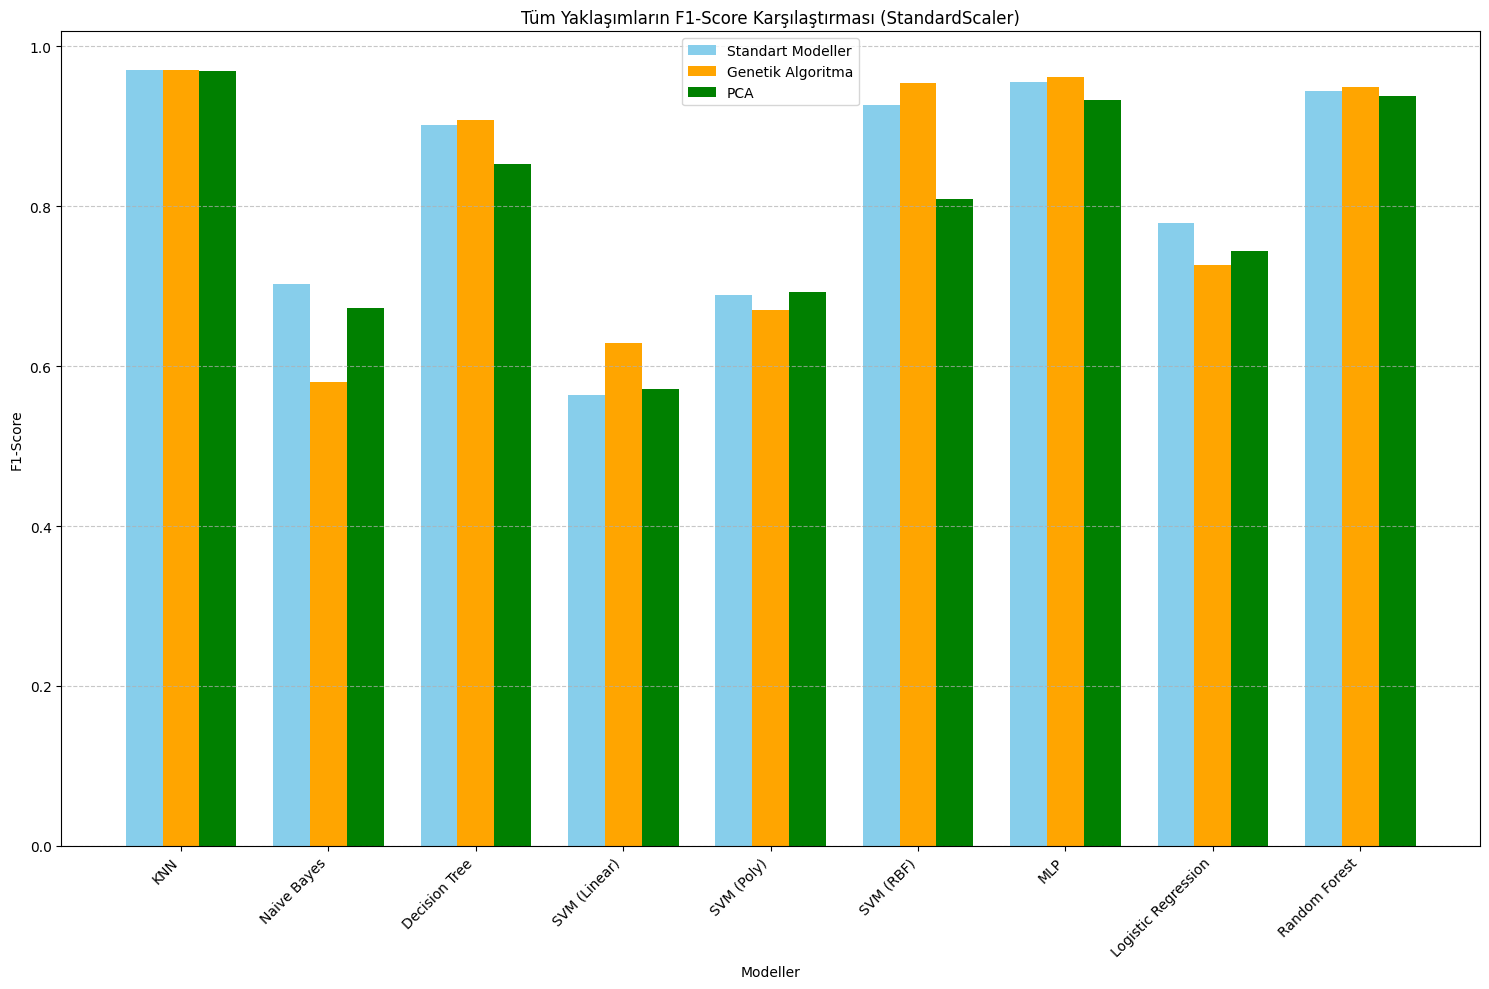


StandardScaler ile analiz tamamlandı. Sonuçlar CSV dosyalarına ve grafik olarak kaydedildi.


In [ ]:
if __name__ == "__main__":
    main()